# Multiclass Support Vector Machine
In this exercise, we will
- implement a **fully-vectorized loss function** for SVM
- implement the fully-vectorized expression for its analytic gradient
- check the implementation using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with SGD
- **visualize** the final learned weights

## Basic settings

In [1]:
# Import the esential libs
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10

In [2]:
# set the matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# optional setting
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

# Cifar-10 Data loading and preprocessing

In [3]:
# Load the raw CIFAR-10 data.
X_tr, y_tr, X_te, y_te = load_CIFAR10('D:/CS231N_CNN/DataSet/cifar-10-batches-py/')
# As a sanity check, we print out the size of the traning ans test data
print('Training data shape:   ', X_tr.shape)
print('Training labels shape: ', y_tr.shape)
print('Test data shape:       ', X_te.shape)
print('Test labels shape:     ', y_te.shape) 

D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_1
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_2
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_3
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_4
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_5
Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:        (10000, 32, 32, 3)
Test labels shape:      (10000,)


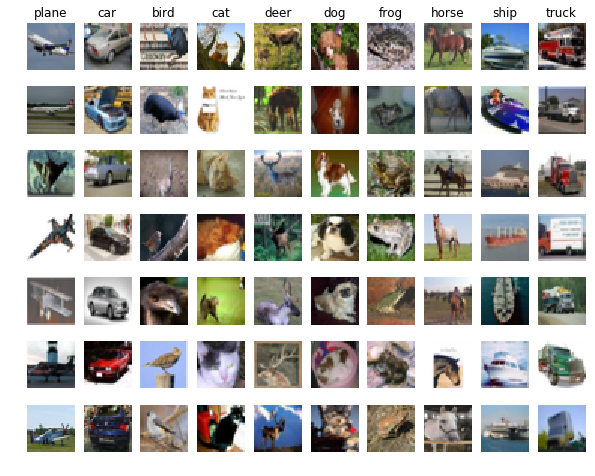

In [4]:
# visualize some examples from the dataset
# We show a few examples of trainging images from each class
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_tr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_tr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)


plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
num_validation = 1000
num_test = 1000

# Validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_tr[mask]
y_val = y_tr[mask]

# Training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_tr[mask]
y_train = y_tr[mask]

# Use the first num_test points of the original test set as the test set.
mask = range(num_test)
X_test = X_te[mask]
y_test = y_te[mask]

print('Train data shape:        ', X_train.shape) 
print('Train labels shape:      ', y_train.shape) 
print('Validation data shape:   ', X_val.shape) 
print('Validation labels shape: ', y_val.shape) 
print('Test data shape:         ', X_test.shape) 
print('Test labels shape:       ', y_test.shape) 

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape) 
print('Validation data shape: ', X_val.shape) 
print('Test data shape:       ', X_test.shape) 

Train data shape:         (49000, 32, 32, 3)
Train labels shape:       (49000,)
Validation data shape:    (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:          (1000, 32, 32, 3)
Test labels shape:        (1000,)
Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)


(3073, 49000) (3073, 1000) (3073, 1000)


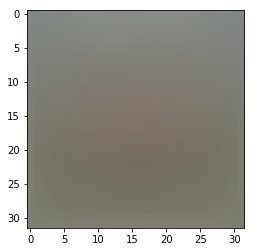

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis = 0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
# second: substract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print(X_train.shape, X_val.shape, X_test.shape)

In [7]:
del X_tr

**Inline Question 0**

Why the mean iamge is subtracted from the data set?

## SVM calssfier

Firstly, we will evaluate the naive implementation of the loss.
In muilticlass SVM, we use **hinge loss** to calculate the loss function.

![](hingleoss.jpg)

The Multiclass Support Vector Machine "wants" the score of the correct class to be higher than all other scores by at least a margin of delta. If any class has a score inside the red region (or higher), then there will be accumulated loss. Otherwise the loss will be zero. Our objective will be to find the weights that will simultaneously satisfy this constraint for all examples in the training data and give a total loss that is as low as possible.

Including the **regularization penalty** completes the full Multiclass Support Vector Machine loss, which is made up of two components: the **data loss** (which is the average loss $L_i$ over all examples) and the regularization loss. That is, the full Multiclass SVM loss becomes:

$$
L = \frac{1}{N}\sum\limits_i {\sum\limits_{j \ne {y_i}} {\left[ {\max \left( {0,f{{\left( {{x_i};W} \right)}_j} - f{{\left( {{x_i};W} \right)}_{{y_i}}} + \Delta } \right)} \right]} }  + \lambda \sum\limits_k {\sum\limits_l {W_{k,l}^2} }
$$

Where **$N$** is the number of training examples. As you can see, we append the regularization penalty to the loss objective, weighted by a hyperparameter **$\lambda$**. There is no simple way of setting this hyperparameter and it is usually determined by cross-validation.

In *svm_loss_naive.py*, we calculate the loss one training image after another.
```python
for i in range(num_train):
        scores = W.dot(X[:,i])
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:   # if correct class
                continue
            margin = scores[j]-correct_class_score+delta
            if margin > 0: 
                loss += margin
                # dW_j = partial(loss)/partial(w_j) = X_i.T
                # dW_y = partial(loss)/partial(w_y) = -X_i.T
                # Compute dW_j and dW_y simulataneously
                dW[j,:] += X[:,i].T      
                dW[y[i],:] -= X[:,i].T
```
Note that, in this program, **WHY** dose the gradient of $W$ corresponding to the groundtruth label calculate like this? 

Lets use the example of the SVM loss function for a single datapoint:

$$
{L_i} = \sum\limits_{j \ne {y_i}} {\left[ {\max \left( {0,w_j^T{x_i} - w_{{y_i}}^T{x_i} + \Delta } \right)} \right]}
$$

Taking the gradient with respect to ${{w_{{y_i}}}}$ we obtain:

$$
{\nabla _{{w_{{y_i}}}}}{L_i} =  - \left( {\sum\limits_{j \ne {y_i}} {{\bf{1}}\left( {w_j^T{x_i} - w_{{y_i}}^T{x_i} + \Delta  > 0} \right)} } \right)x_i
$$

where ${\bf{1}}$ is the indicator function that is one if the condition inside is true or zero otherwise. While the expression may look scary when it is written out, when you’re implementing this in code you’d simply **count the number of classes that didn’t meet the desired margin** (and hence contributed to the loss function) and then the data vector ${{x_i}}$ scaled by this number is the gradient. Notice that this is the gradient only with respect to the row of WW that corresponds to the correct class. For the other rows where ${j \ne {y_i}}$ the gradient is:

$$
{\nabla _{{w_j}}}{L_i} = {\bf{1}}\left( {w_j^T{x_i} - w_{{y_i}}^T{x_i} + \Delta  > 0} \right)x_i
$$

### SVM Loss with naive implementation

In [8]:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(num_classes, X_train.shape[0]) * 0.001
# Naive implementation of the loss
loss, grad = svm_loss_naive(W, X_train, y_train, 0.00001)
print('svm loss naive is %f' % loss)

svm loss naive is 21.085300


### gradient check
To check that you have correctly implemented the gradient correctly, you can **numerically estimate the gradient of the loss function** and compare the numeric estimate to the gradient that you computed.

 The mathematical expression for the derivative of a 1-D function with respect its input is:
 
 $$
 \frac{{df\left( x \right)}}{{dx}} = \mathop {\lim }\limits_{h \to 0} \frac{{f\left( {x + h} \right) - f\left( x \right)}}{h}
 $$
 
 When the functions of interest take a vector of numbers instead of a single number, we call the **derivatives partial** derivatives, and the gradient is simply the vector of partial derivatives in each dimension.
 
**Practical considerations**

Note that in the mathematical formulation the gradient is defined in the limit as $h$ goes towards zero, but in practice it is often sufficient to use a very small value (such as 1e-5 as seen in the example). Ideally, you want to use the smallest step size that does not lead to numerical issues. Additionally, in practice it often works better to compute the numeric gradient using the **centered difference formula**:  

$$
\frac{{df\left( x \right)}}{{dx}} = \mathop {\lim }\limits_{h \to 0} \frac{{f\left( {x + h} \right) - f\left( {x - h} \right)}}{{2h}}
$$

so in the function gradient_check.py, it can be seen:
```python
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5
    x.shape
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h        # increment by h 
        fxph = f(x)       # evaluate f(x+h)
        x[ix] -= 2 * h     # decrement by h
        fxmh = f(x)       # evaluate f(x-h)
        x[ix] += h        # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        ...
```

In [9]:
from cs231n.gradient_check import grad_check_sparse

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
# First, compute its gradient at W.
_, grad = svm_loss_naive(W, X_train, y_train, 0.0)
f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.355955 analytic: 2.355540, relative error: 8.803943e-05
numerical: -10.101647 analytic: -10.100293, relative error: 6.706045e-05
numerical: 8.919343 analytic: 8.919077, relative error: 1.489839e-05
numerical: 2.830244 analytic: 2.830352, relative error: 1.906027e-05
numerical: -31.252477 analytic: -31.252589, relative error: 1.788762e-06
numerical: -0.243496 analytic: -0.242889, relative error: 1.248995e-03
numerical: 11.169152 analytic: 11.168680, relative error: 2.113520e-05
numerical: 1.572137 analytic: 1.571491, relative error: 2.053677e-04
numerical: -5.386889 analytic: -5.387434, relative error: 5.059025e-05
numerical: 5.903010 analytic: 5.903024, relative error: 1.175568e-06


**nline Question 1**:

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? **Hint: the SVM loss function is not strictly speaking differentiable**

**Answer:**

The gradient could not be strictly differentiable, as in our hinge loss case. In a 1D case, a point right before the hinge should have an analytical gradient of 0, while the numerical gradient would be greater than 0.

### SVM Loss with vectorization implementation
Second, we will evaluate the an efficient implementation of the loss with **vectorization**.

(1) **scores**
```python
scores = np.dot(W, X) # also known as f(x_i, W), C x N dimension

correct_scores = np.ones(scores.shape) * scores[y, np.arange(0, scores.shape[1])]
# correct_scores is a C x N dimensional array, each element in the same column
# is same.
```
for example:
```python
scores = np.array([[1,2,3,0],[2,2,1,0],[3,1,0,3],[1,3,0,1]])
scores
-> [1,2,3,0,
    2,2,1,0,
    3,1,0,3,
    1,3,0,1]
np.ones(scores.shape) * scores[y, np.arange(0, scores.shape[1])]
-> [1,2,0,1,
    1,2,0,1,
    1,2,0,1,
    1,2,0,1]
```

(2) **Loss** (without regularization)
```python
deltas = np.ones(scores.shape)
L = scores - correct_scores + deltas

L[L < 0] = 0
L[y, np.arange(0, scores.shape[1])] = 0 # do not count y_i
loss = np.sum(L)
```

(3) **gradient**
```python
L = scores - correct_scores + deltas   # (C x N) dimension
L[L < 0] = 0
L[L > 0] = 1  # including the groundtruth

L[y, np.arange(0, scores.shape[1])] = 0     # do not count y_i
L[y, np.arange(0, scores.shape[1])] = -1 * np.sum(L, axis = 0) 
# Note:
#     S_y计入loss的个数是np.sum(L, axis = 0)

dW = np.dot(L, X.T)
```


In [10]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized

tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc-tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('Vectorized loss:%e computed in %s' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('loss difference: %f' % (loss_naive - loss_vectorized))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Gradient difference: %f' % difference)

Naive loss: 2.108530e+01 computed in 2.051957s
Vectorized loss:2.108530e+01 computed in 0.31383442878723145
loss difference: -0.000000
Gradient difference: 0.000002


##  Stochastic Gradient Descent (SGD)

As we have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

iteration 0 / 1500: loss 787.331288
iteration 100 / 1500: loss 771.150326
iteration 200 / 1500: loss 769.307008
iteration 300 / 1500: loss 764.696715
iteration 400 / 1500: loss 762.160006
iteration 500 / 1500: loss 759.076850
iteration 600 / 1500: loss 756.818365
iteration 700 / 1500: loss 756.750285
iteration 800 / 1500: loss 752.519927
iteration 900 / 1500: loss 751.922334
iteration 1000 / 1500: loss 750.416804
iteration 1100 / 1500: loss 747.426875
iteration 1200 / 1500: loss 745.073684
iteration 1300 / 1500: loss 744.245629
iteration 1400 / 1500: loss 741.705047
That took 6.432028s


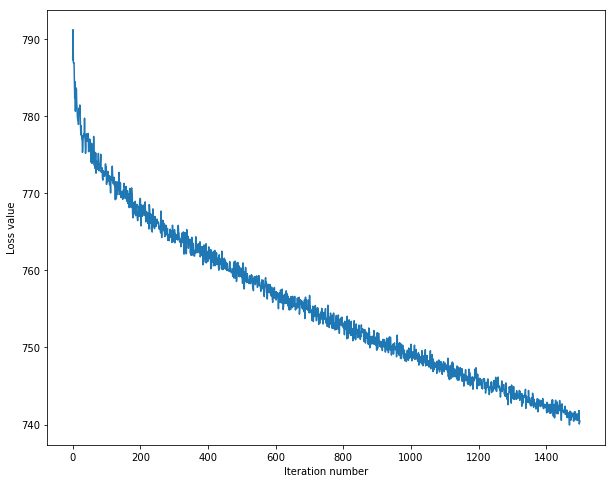

In [11]:
from cs231n.classifiers.linear_classifier import LinearSVM, LinearClassifier
# Now implement SGD in LinearSVM.train() function and run it with the code below
svm = LinearSVM()

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate = 1e-7, reg = 5e4, num_iters=1500, verbose=True)
toc = time.time()

print('That took %fs' % (toc - tic))

# A useful debugging strategy is to plot the loss as a function of
# iteration number.
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

evaluate the performance on both training and validation set using the predict() function

In [12]:
y_train_pred = svm.predict(X_train)
print('training accuracy:%f' % (np.mean(y_train == y_train_pred)))
y_val_pred = svm.predict(X_val)
print('validation accuracy:%f' % (np.mean(y_val == y_val_pred)))

training accuracy:0.302429
validation accuracy:0.313000


### Validation
use the **validation set** to **tune hyperparameter (regularization strength and learning rate)**. You should experiment with different ranges for the learning rates and regularization strengths

In [13]:
# choices for the regularization strength and learning_rate
learning_rates = [1e-7, 2e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 2e4, 5e4, 1e5, 5e5, 1e6]

In [14]:
# results are dictionary mapping tuples of the form 
# (learning_rate, regularization_strength) to tuples of the form 
# (training_accuracy, validation_accuracy). The accuracy is simply the fration 
# of data points that are correctly classified.

results = {}
best_val = -1    # The highest validation accuracy that we have seen so far.
best_svm = None  # The LinearSVM object that chieved the highest validation rate.

for learning in learning_rates:
    for regularition in regularization_strengths:

        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=learning, reg = regularition, num_iters=2000)

        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)

        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
            print('best val is %f' % best_val)

        results[(learning, regularition)] = (training_accuracy, validation_accuracy)
        print('learning rate %e,regularization %e. train accuracy:%f val accuracy: %f' % (learning, regularition, training_accuracy, validation_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

best val is 0.292000
learning rate 1.000000e-07,regularization 1.000000e+04. train accuracy:0.307082 val accuracy: 0.292000
best val is 0.298000
learning rate 1.000000e-07,regularization 2.000000e+04. train accuracy:0.308755 val accuracy: 0.298000
best val is 0.329000
learning rate 1.000000e-07,regularization 5.000000e+04. train accuracy:0.312327 val accuracy: 0.329000
best val is 0.331000
learning rate 1.000000e-07,regularization 1.000000e+05. train accuracy:0.312306 val accuracy: 0.331000
learning rate 1.000000e-07,regularization 5.000000e+05. train accuracy:0.317082 val accuracy: 0.329000
learning rate 1.000000e-07,regularization 1.000000e+06. train accuracy:0.316306 val accuracy: 0.306000
best val is 0.336000
learning rate 2.000000e-07,regularization 1.000000e+04. train accuracy:0.341163 val accuracy: 0.336000
best val is 0.353000
learning rate 2.000000e-07,regularization 2.000000e+04. train accuracy:0.332122 val accuracy: 0.353000
learning rate 2.000000e-07,regularization 5.000000

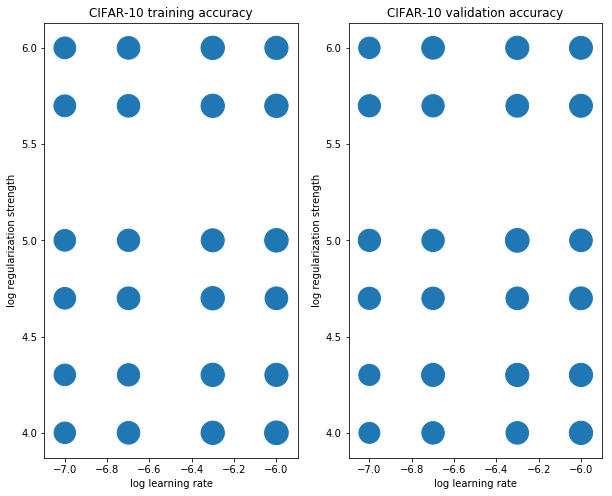

In [15]:
import math
# Visualize the cross-validation results
    
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
sz = [results[x][0]*1500 for x in results]
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
sz = [results[x][1]*1500 for x in results]
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.303000


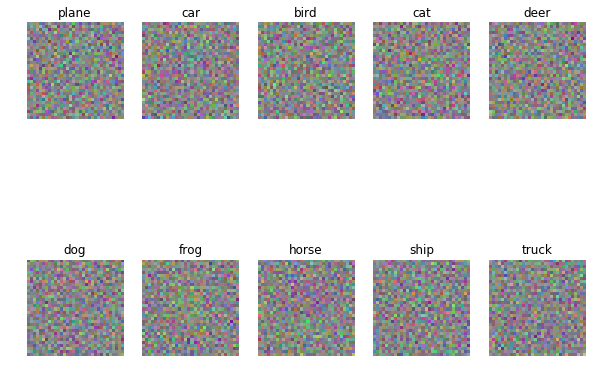

In [17]:
# Visulize the learned weights for each class.
# Depending on your choice of learning rate and regularition strength, these may 
# or may not be nice to look at.

w = best_svm.W[:,:-1]     # strip out the bias
w = w.reshape(10,32,32,3)
w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i+1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

plt.show()